APROXIMATE RUN TIME OF THE WHOLE QUESTION IS ABOUT 30 MINUTES( specs: i7 6700HQ, 16gb DDR4)

However, some cells with GridSearch can be skipped but NOT the cells that train our models!

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as  plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import sem
#ignore warnings about module depreciation
import warnings
warnings.filterwarnings("ignore") 
%matplotlib inline

data_filename_train = 'train.csv'
data_filename_test = 'test.csv'
data_filename_submission = 'sample_submission.csv'

df_train = pd.read_csv(data_filename_train)
df_test = pd.read_csv(data_filename_test)
df_submission = pd.read_csv(data_filename_submission)

#merge submission with test so if we drop some rows later the dfs stay matched
df_test = df_test.merge(df_submission, left_on ='Id' , right_on = 'Id' , how = 'inner')

Handle missing values:

We will merge train and test DFs so we can handle all missing values at once.

Then we will split the df to categorical and quantitive variables to proccess them correspondingly. 

At the end, we will split the df to train and test dataframes so we can run the models properly.

In [2]:
#merge train&test
df = df_train.append(df_test, ignore_index=True)

In [3]:
#check for duples for Id
idsUnique = len(set(df['Id']))
idsTotal = df.shape[0]
idsdupe = idsTotal - idsUnique
print(idsdupe)

0


In [4]:
#Count missing values per column
df_nas = df.isnull().sum()
df_nas = df_nas[df_nas>0]
df_nas.sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

Simple Option: Drop Columns with Missing Values

Maybe this is not the best option because we will probably loose some usefull information.
On the other hand, these columns are highly correlated with other columns of the dataset so maybe this is not a big problem.

E.g. we will drop column PoolQuality but we still have information about PoolArea, (the same applies for the Garage and the other variables we drop).
However, for the last variables that have only a few rows with NaNs, we choose to drop those rows instead of the whole columns.

Another approach to this problem is Imputation. However, in most features this is not a good practice.
If we replace the NaNs with the most frequent class for categorical variables we will create false information.
For example, PoolQC(Pool quality) includes NaNs on the houses that do not have a pool so if we add the mode(most frequent class) on these NaNs is like we add a pool on those houses.

In [5]:
#Handle missing values
exclude = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']

#Drop feutures with NaNs > 25
df = df.drop(exclude, axis=1, errors = 'ignore')
#Drop rows(We will drop 20 rows and we will avoid dropping 18columns) 
df = df.dropna(axis = 0, how='any')

In [6]:
#Set Id column as index because we don't want this feature in our analysis.
#Id is just an increment feature that shouldn't influence our models.
df = df.set_index('Id')

In [7]:
#split the df to categorical and continues features
df_cat = df.select_dtypes(include=['object'])
df_cont = df.select_dtypes(exclude=['object'])

#make numeric the continous feutures
df_cont = df_cont.apply(pd.to_numeric, errors='ignore')

In [8]:
#create dummies for categorical variables
df_cat = pd.get_dummies(df_cat)

Now we will merge Numeric and Categorical dataframes.

Then we will SPLIT to Train and Test DataFrames.

In [9]:
df_new = df_cont.join(df_cat)

# -8 because we dropped 8 rows from the training dataframe
df_train = df_new.iloc[:len(df_train) - 8]
df_test =  df_new.iloc[len(df_train) + 8:]

#create our model variables
train_x = df_train.loc[:, df_train.columns != 'SalePrice']
#target variable
train_y = df_train['SalePrice']

#testing df
test_x = df_test.loc[:, df_test.columns != 'SalePrice']
#true SalePrices to evaluate our model
test_y = df_test['SalePrice']

MODELS EVALUATION

There are many ways to evaluate each model. In our example we will evaluate our models with the mean(cross_val_score).In that way, we can score our model in many different pseudo-test sets and find a general score for our model.

More specificaly, if we just evaluated our model from the mean absolute error and the mean square error of the predicted prices vs the true prices of the test dataframe we probably get better MSE/MAE on a model that happens by chance to fit better on the test dataframe.

Also, in a real world ML cases we wont have the results of the test dataframe so we have to evaluate our models without knowing the true results.

1st Model: DecisionTree(Regressor, because we want to predict a continues variable) 

Simple explanation:
We split our data iteratively on the split point with the greatest variance reduction.
Because we have many features the decision tree will try all points of all the features pick and finally will choose the best split-point(with the greatest variance reduction).
The best split point is determined by the mean square error(mse).
It is challenging to find the optimal number of splits. If you split in a big depth you may end up to overfit
the model on your training data and end up with a worse prediction on your test data.

In [10]:
#create a dataframe to collect model's evaluators so we can compare them at the end.
Models_Results = pd.DataFrame()
Models_Results['Evaluators'] = ['mean_cv_score', 'stand.error_mean_score','MAE_test', 'MSE_test']

In [11]:
#FIRST MODEL
#we create a list of parameters just to show the practice of how tuning works.
parameters = [
    {'max_depth': list(range(5, 15))},
    {'min_samples_split': [2,3,4]}
    ]

cv = KFold(n_splits=11, shuffle=True, random_state=13)

clf = GridSearchCV(DecisionTreeRegressor(criterion='mse'), parameters, cv = cv)

clf = clf.fit(test_x, test_y)
#clf.get_params() this is a nice function to see all the parameters of your model.
print(clf.best_estimator_)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')


In [12]:
#we copy-pasted the best_estimator_ parameters from the cell above. 
price_tree = DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
               max_leaf_nodes=None, min_impurity_split=1e-07,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, presort=False, random_state=None,
               splitter='best')

#train our model
price_tree.fit(train_x, train_y)

#predict prices from the test data
predicted_prices = price_tree.predict(test_x)

#evaluate our model from cross_val_score (have been explained earlier why we use cvs)
scores = cross_val_score(price_tree, train_x, train_y, cv=cv)
mean_score = format(np.mean(scores), '.3f')
sem_score = format(sem(scores), '.02')

#calculate mse and msa for the predicted prices
mae = format(mean_absolute_error(test_y, predicted_prices), '.0f')
mse = format(mean_squared_error(test_y, predicted_prices), '.0f') 

#store our results in the Models_Results so we can compare all models at the end.
Models_Results['DecisionTree'] = [mean_score, sem_score, mae, mse]
print('DecisionTreeRegressor Scores:')
print('Mean crossvalidation score :', mean_score)
print('Standard error of crossval mean', sem_score)
print('Mean Absolute Error :' , mae)
print('Mean Square Error :' , mse)

DecisionTreeRegressor Scores:
Mean crossvalidation score : 0.766
Standard error of crossval mean 0.028
Mean Absolute Error : 57271
Mean Square Error : 6045681432


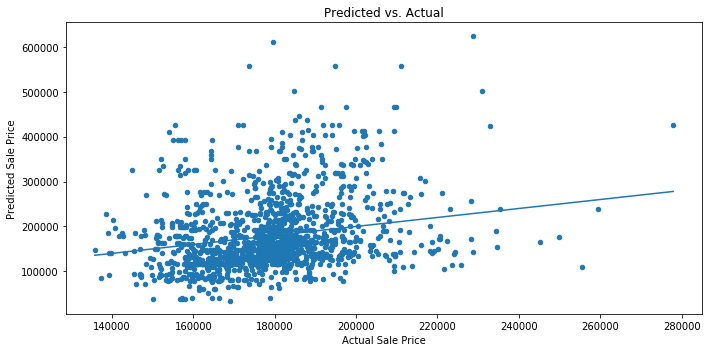

In [13]:
#This is a plot that we can visualise our predicted results versus the actual prices.
#It is obvious that our model needs a lot of improvement to become a good model.
#Even though, it is obvious that our results have some sense.
plt.figure(figsize=(10, 5))
plt.scatter(test_y, predicted_prices, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)])
plt.tight_layout()

2nd Model: Bagging with DecisionTrees

A nice technique to reduce bias of our model is BAGGING.

The Bagging technique is quite simple. Construct  many regression trees from bootstrapped training sets, and average the resulting predictions.

Boostrap is a technique that you take repeated samples from a (single) training dataset. 

In [14]:
#SECOND MODEL: BAGGING DECISIONTREES
#create a simple DecisionTree
simple_tree = DecisionTreeRegressor(random_state=0)

#n_estimators specifies how many base estimators(trees) will be used in the ensemble.
#We could also DridSearch on this parameter to find the optimal parameters.
#n_jobs indicates how proccessors run in parallel. If n_jobs=-1 we'll have as many jobs as processors in parallel.
bagging_price_tree = BaggingRegressor(simple_tree, n_estimators=50, n_jobs=-1, random_state = 0)
bagging_price_tree.fit(train_x, train_y)
predicted_prices = bagging_price_tree.predict(test_x)

scores = cross_val_score(bagging_price_tree, train_x, train_y, cv=cv)
mean_score = format(np.mean(scores), '.3f')
sem_score = format(sem(scores), '.03f')
mae = format(mean_absolute_error(test_y, predicted_prices), '.0f')
mse = format(mean_squared_error(test_y, predicted_prices), '.0f') 

Models_Results['BaggingTrees'] = [mean_score, sem_score,mae,mse]
print('Bagging with DecisionsTrees Scores:')
print('Mean crossvalidation score :', mean_score)
print('Stand.err of the mean of the scores :', sem_score)
print('Mean Absolute Error :', mae)
print('Mean Squared Error :', mse)

Bagging with DecisionsTrees Scores:
Mean crossvalidation score : 0.854
Stand.err of the mean of the scores : 0.022
Mean Absolute Error : 53665
Mean Squared Error : 4965225269


3rd Random Forest:

Simple explanation
RandomForest is an improvement of the Bagged trees. As in bagging we build a number of decision trees with bootstrapped training samples, in this case we do the same process but each tree uses only a random sample of m  predictors(features). In this way we can decorrelate the trees. 

With bagging if there are very strong predictors in the data set, all the trees will use these predictors on their upper splits. Therefore, all the bagged trees will look quite similar and the predictions given by the individual trees will be highly correlated.

In [15]:
#THIRD MODEL: RandomForest (This task takes approximately ~10min, at my PC but you can SKIP IT)
#In order to present how tuning works we implement a variety of parameters but in a short range due to the computer power limitations. 
#Set the parameters
tuned_parameters = {'n_estimators': [50, 100, 500, 700], 
                    'max_depth': list(range(5,12)), 
                    'min_samples_split': [2, 3],
                    'oob_score': [True,False]}

#try all the combinations of the parameters above with GridSearchCV function
clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, 
           n_jobs=-1, verbose=1)

clf.fit(train_x, train_y)
print(clf.best_estimator_)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:  9.2min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [16]:
#we take the RF model with the best parameters from the previous cell and we paste it here to create our final model and predict the SalePrices.
RF_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state= 0,
           verbose=0, warm_start=False)

#train our model from the training data
RF_model.fit(train_x, train_y)
#predict the prices from the testing dataset
predicted_prices = RF_model.predict(test_x)

cv = KFold(n_splits=11, shuffle=True, random_state=13)
scores = cross_val_score(RF_model, train_x, train_y, cv=cv)
mean_score = format(np.mean(scores), '0.3f')
sem_score = format(sem(scores), '0.03f')
mae = format(mean_absolute_error(test_y, predicted_prices), '.0f')
mse = format(mean_squared_error(test_y, predicted_prices), '.0f') 

Models_Results['RandomForest'] = [mean_score, sem_score,mae,mse]
print('RandomForest Scores:')
print('Mean cross-validation score :', mean_score)
print('Stand.err of the mean of the scores :', sem_score)
print('Mean Absolute Error :', mae)
print('Mean Square Error :', mse)

RandomForest Scores:
Mean cross-validation score : 0.854
Stand.err of the mean of the scores : 0.022
Mean Absolute Error : 53633
Mean Square Error : 4988233414


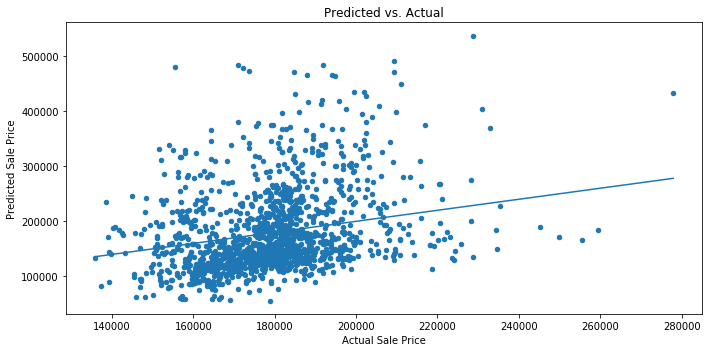

In [17]:
plt.figure(figsize=(10, 5))
plt.scatter(test_y, predicted_prices, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)])
plt.tight_layout()

Simple Explanation:AdaBoost regressor.

An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

It fits a sequence of weak learners on different weighted training data. It starts by predicting original data set and gives equal weight to each observation. If prediction is incorrect using the first learner, then it gives higher weight to the observation which have been predicted incorrectly. Being an iterative process, it continues to add learners until a limit is reached in the number of models or accuracy.
All in all, with AdaBoostRegressor, each classifier gets its own weight accordingly to its importance.

In [18]:
#FOURTH MODEL: ADABOOSTREGRESSOR
#about 10mins to run
rgr = AdaBoostRegressor(price_tree, n_estimators=1000, random_state = 0)
rgr.fit(train_x, train_y)

predicted_prices = rgr.predict(test_x)

scores = cross_val_score(rgr, train_x, train_y, cv=cv)
mean_score = format(np.mean(scores), '.3f')
sem_score = format(sem(scores), '.03f')
mae = format(mean_absolute_error(test_y, predicted_prices), '.0f')
mse = format(mean_squared_error(test_y, predicted_prices), '.0f') 

Models_Results['AdaBoost'] = [mean_score, sem_score, mae, mse]
print('AdaptiveBoostRegressor Scores:')
print('Mean crossvalidation score :', mean_score)
print('Stand.err of the mean of the scores :', sem_score)
print('Mean Absolute Error :', mae)
print('Mean Square Error :', mse)

AdaptiveBoostRegressor Scores:
Mean crossvalidation score : 0.867
Stand.err of the mean of the scores : 0.020
Mean Absolute Error : 53159
Mean Square Error : 4941909333


In [19]:
#OTHER MODELS: Lets try the most known  Generalized Linear Models
#More explanation about how linear models work have been given on the Assignement 3 (Question 2).
#This time we dont focus on the mechanism behind those models. 
#We will just try different linear models to show and compare the results.
#However, we should check first the assumptions of these models before we use them.

OLS = linear_model.LinearRegression(n_jobs =-1)
OLS.fit(train_x, train_y)       

predicted_prices = OLS.predict(test_x)

scores = cross_val_score(OLS, train_x, train_y, cv=cv)
mean_score = format(np.mean(scores), '.2f')
sem_score = format(sem(scores), '.03')
mae = format(mean_absolute_error(test_y, predicted_prices), '.0f')
mse = format(mean_squared_error(test_y, predicted_prices), '.0f') 

Models_Results['OLS'] = [mean_score,sem_score,mae,mse]
print('Ordinary Least Squares Scores:')
print('Mean crossvalidation score :', mean_score)
print('Stand.err of the mean of the scores :', sem_score)
print('Mean Absolute Error :', mae)
print('Mean Square Error :', mse)

Ridge = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], fit_intercept = True, normalize = True)
Ridge.fit(train_x, train_y)
predicted_prices = Ridge.predict(test_x)

scores = cross_val_score(Ridge, train_x, train_y, cv=cv)
mean_score = format(np.mean(scores), '.3f')
sem_score = format(sem(scores), '.03f')
mae = format(mean_absolute_error(test_y, predicted_prices), '.0f')
mse = format(mean_squared_error(test_y, predicted_prices), '.0f') 

Models_Results['Ridge'] = [mean_score,sem_score,mae,mse]
print()
print('Ridge Regression Variance Scores:')
print('Mean crossvalidation score :', mean_score)
print('Stand.err of the mean of the scores :', sem_score)
print('Mean Absolute Error :', mae)
print('Mean Square Error :', mse)

Lasso = linear_model.Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
                           normalize=False, positive=False, precompute=False, random_state=0,
                            selection='cyclic', tol=0.0001, warm_start=False)

Lasso.fit(train_x, train_y)
predicted_prices = Lasso.predict(test_x)

scores = cross_val_score(Lasso, train_x, train_y, cv=cv)
mean_score = format(np.mean(scores), '.2f')
sem_score = format(sem(scores), '.03f')
mae = format(mean_absolute_error(test_y, predicted_prices), '.0f')
mse = format(mean_squared_error(test_y, predicted_prices), '.0f') 

Models_Results['Lasso'] = [mean_score,sem_score,mae,mse]
print()
print('Lasso Scores:')
print('Mean crossvalidation score :', mean_score)
print('Stand.err of the mean of the scores :', sem_score)
print('Mean Absolute Error :', mae)
print('Mean Square Error :', mse)

Ordinary Least Squares Scores:
Mean crossvalidation score : 0.79
Stand.err of the mean of the scores : 0.0538
Mean Absolute Error : 56697
Mean Square Error : 5673731828

Ridge Regression Variance Scores:
Mean crossvalidation score : 0.806
Stand.err of the mean of the scores : 0.041
Mean Absolute Error : 55676
Mean Square Error : 5384897190

Lasso Scores:
Mean crossvalidation score : 0.80
Stand.err of the mean of the scores : 0.051
Mean Absolute Error : 56686
Mean Square Error : 5671602527


Here we will explore the most important features of RandomForest and AdaBoost models side by side so we can compare them

In [22]:
# ~3min run time
X = train_x
Y = train_y

#no need to fit our models again if we already have dont it above
#RF_model.fit(X, Y)
#rgr.fit(X,Y)

importances_RF = RF_model.feature_importances_
importances_AdaBoost = rgr.feature_importances_

std_RF = np.std([tree.feature_importances_ for tree in RF_model.estimators_],
             axis=0)
std_AdaBoost = np.std([tree.feature_importances_ for tree in rgr.estimators_],
             axis=0)

indices_RF = np.argsort(importances_RF)[::-1]
indices_AdaBoost = np.argsort(importances_AdaBoost)[::-1]

most_important_f_RF = []
most_important_f_AdaBoost = []

for f in range(0,10):
    most_important_f_RF.append(str(train_x.columns[indices_RF[f]] + '   ' + format(importances_RF[indices_RF[f]], '.03f')))
    most_important_f_AdaBoost.append(str(train_x.columns[indices_AdaBoost[f]] + '   ' + format(importances_AdaBoost[indices_AdaBoost[f]], '.03f')))

top_feutures = pd.DataFrame(
    {'RandomFores': most_important_f_RF,
     'AdaBoost': most_important_f_AdaBoost    
    })

top_feutures

,AdaBoost,RandomFores
0,OverallQual 0.406,OverallQual 0.592
1,2ndFlrSF 0.144,GrLivArea 0.109
2,GarageCars 0.091,TotalBsmtSF 0.044
3,GrLivArea 0.078,BsmtFinSF1 0.031
4,BsmtFinSF1 0.032,2ndFlrSF 0.031
5,TotalBsmtSF 0.030,GarageCars 0.026
6,1stFlrSF 0.026,1stFlrSF 0.022
7,LotArea 0.018,GarageArea 0.018
8,MasVnrArea 0.017,YearBuilt 0.012
9,TotRmsAbvGrd 0.016,LotArea 0.011


From the output of the previous cell we can see the top 10 important features for the 2 models.
On both models the most important feature is the OverallQuality of the house and this variable determines about the 50% of the prediction of the price.
In general the features are almost the same in both models with small discrepancies on their importance.
Now lets visualise them.

(-1, 10)

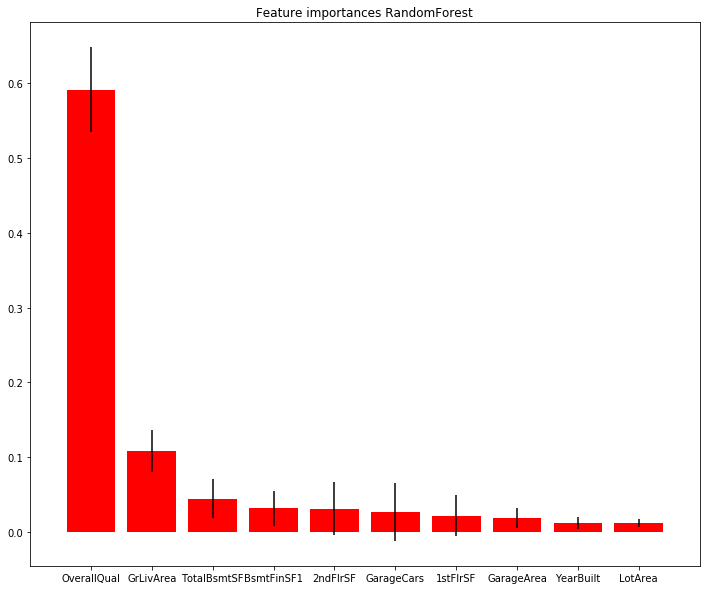

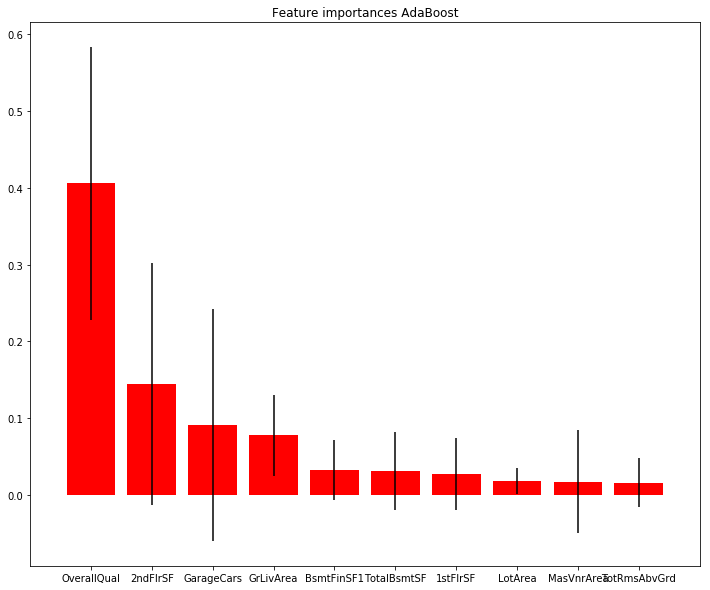

In [23]:
# Plot the feature importances of the forest
plt.tight_layout()

plt.figure(figsize=(12, 10))
plt.title("Feature importances RandomForest")
plt.bar(range(10), importances_RF[indices_RF[0:10]],
       color="r", yerr=std_RF[indices_RF[0:10]], align="center")
plt.xticks(range(10), train_x.columns[indices_RF[0:10]])
plt.xlim([-1, 10])

plt.figure(figsize=(12, 10))
plt.title("Feature importances AdaBoost")
plt.bar(range(10), importances_AdaBoost[indices_AdaBoost[0:10]],
       color="r", yerr=std_AdaBoost[indices_AdaBoost[0:10]], align="center")
plt.xticks(range(10), train_x.columns[indices_AdaBoost[0:10]])
plt.xlim([-1, 10])

To conclude we will print all model's results to compare them side by side.

In [24]:
Models_Results

,Evaluators,DecisionTree,BaggingTrees,RandomForest,AdaBoost,OLS,Ridge,Lasso
0,mean_cv_score,0.766,0.854,0.854,0.867,0.79,0.806,0.80
1,stand.error_mean_score,0.028,0.022,0.022,0.020,0.0538,0.041,0.051
2,MAE_test,57271,53665,53633,53159,56697,55676,56686
3,MSE_test,6045681432,4965225269,4988233414,4941909333,5673731828,5384897190,5671602527


All in all, AdaptiveBoostTrees is our best model with the best mean_cross_val_score followed by the RandomForest and BaggingTrees with a slight difference.

However, the case of this assignment is to show and compare different ML models without spending time to tune the models.
So if we had spent a lot of time to tune the parameters of all the models maybe an other model would predict better the prices.

Features selection:

The two models with the best scores(AdaBoost and RandomForest) are using all the variables to predict the prices(Except from those that were excluded on the ETL procces, more detailts are on the comments above).
This is quite normal because even if we have a max depth on those models, RandomForest and AdaBoost are selecting for each estimator(DecTree) a number m of random predictors(features) as have been explained above.

We can prove that on the next cell:

In [26]:
#model.feature_importances_ get the importance for every feature that have been used even if that value is too small.
print('RandomForest uses all the features: ', len(train_x.columns) == len(RF_model.feature_importances_))
print('AdaBoost uses all the features: ', len(train_x.columns) == len(rgr.feature_importances_))

RandomForest uses all the features:  True
AdaBoost uses all the features:  True


All the question have been asked on the assignment have been answered in Markdowns and comments above.